In [7]:
import sys
sys.path.append("../src")
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm

from pipeline import SearchEngine

In [2]:
DATA_PATH = "../data/"
PERSON_ATTRIBUTES_PATH = DATA_PATH + "person-attributes.csv" 

In [3]:
person_attributes_df = pd.read_csv(PERSON_ATTRIBUTES_PATH)
attributes_list = person_attributes_df.columns[1:-1].tolist()
most_common_labels_10 = defaultdict(list)
for attribute in attributes_list:
    most_common_labels_10[attribute] = person_attributes_df[attribute].value_counts().index.tolist()[:10]
queries = ['person', 'woman', 'teacher', 'role model', 'professional']
lambda_list = [1, 0.3, 0.5, 0.7]

In [4]:
search_engine = SearchEngine(ranker='VectorRanker')

Initializing Search Engine...
Loading doc augment dict...


600001it [00:00, 894068.55it/s]


Loading indexes...


100%|██████████| 200000/200000 [00:16<00:00, 11995.20it/s]


Loading ranker...
Loading categories...
Loading recognized categories...


100%|██████████| 200000/200000 [00:00<00:00, 680016.44it/s]


Loading network features...


999842it [00:01, 845274.91it/s]


Loading raw text dict...


9605it [00:00, 984874.46it/s]


Loading cross encoder scorer...
Loading L2R ranker...
Training L2R ranker...
Training model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2390
[LightGBM] [Info] Number of data points in the train set: 9604, number of used features: 122
Search Engine initialized!


In [5]:
def rank_all():
    overall_ranks = []
    for lambda_val in lambda_list:
        for query in queries:
            res = search_engine.pipeline.query(query, mmr_lambda=lambda_val)
            print('lambda=', lambda_val, 'query=', query)
            for idx, (id, score) in tqdm(enumerate(res), total=len(res)):
                person = person_attributes_df[person_attributes_df['docid'] == id]
                if person.empty:
                    continue
                for attribute in attributes_list:
                    if person[attribute].item() in most_common_labels_10[attribute]:
                        overall_ranks.append({
                            'pipeline': 'lambda=' + str(lambda_val),
                            'query': query,
                            'attribute': attribute,
                            'label': person[attribute].item(),
                            'rank': idx + 1
                        })
    overall_ranks = pd.DataFrame(overall_ranks)
    return overall_ranks

In [6]:
overall_ranks = rank_all()
overall_ranks

100%|██████████| 200000/200000 [00:17<00:00, 11694.58it/s]


,pipeline,query,attribute,label,rank
0,lambda=1,person,Gender,female,111
1,lambda=1,person,Religious_Affiliation,Islam,111
2,lambda=1,person,Gender,male,159
3,lambda=1,person,Gender,male,262
4,lambda=1,person,Religious_Affiliation,Catholic Church,262
...,...,...,...,...,...
439475,lambda=0.7,professional,Religious_Affiliation,Catholicism,199093
439476,lambda=0.7,professional,Gender,male,199557
439477,lambda=0.7,professional,Gender,male,199646
439478,lambda=0.7,professional,Gender,male,199886


In [10]:
def plot_all():
    fig, ax = plt.subplots(5, 4, figsize=(20, 20))
    ax = ax.ravel()

    grouped = overall_ranks.groupby(['query', 'attribute'])

    for i, ((query, attribute), group) in enumerate(grouped):
        sns.barplot(x='label', y='rank', hue='pipeline', data=group, ax=ax[i], palette='pastel')
        ax[i].set_title(query)
        ax[i].set_ylim(0, 200000)
        if i < 16:
            ax[i].set_xticklabels('')
            ax[i].set_xlabel('')
        else:
            ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
        if i % 4 != 0:
            ax[i].set_ylabel('')

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_7954/800009601.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_7954/800009601.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_7954/800009601.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_7954/800009601.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)


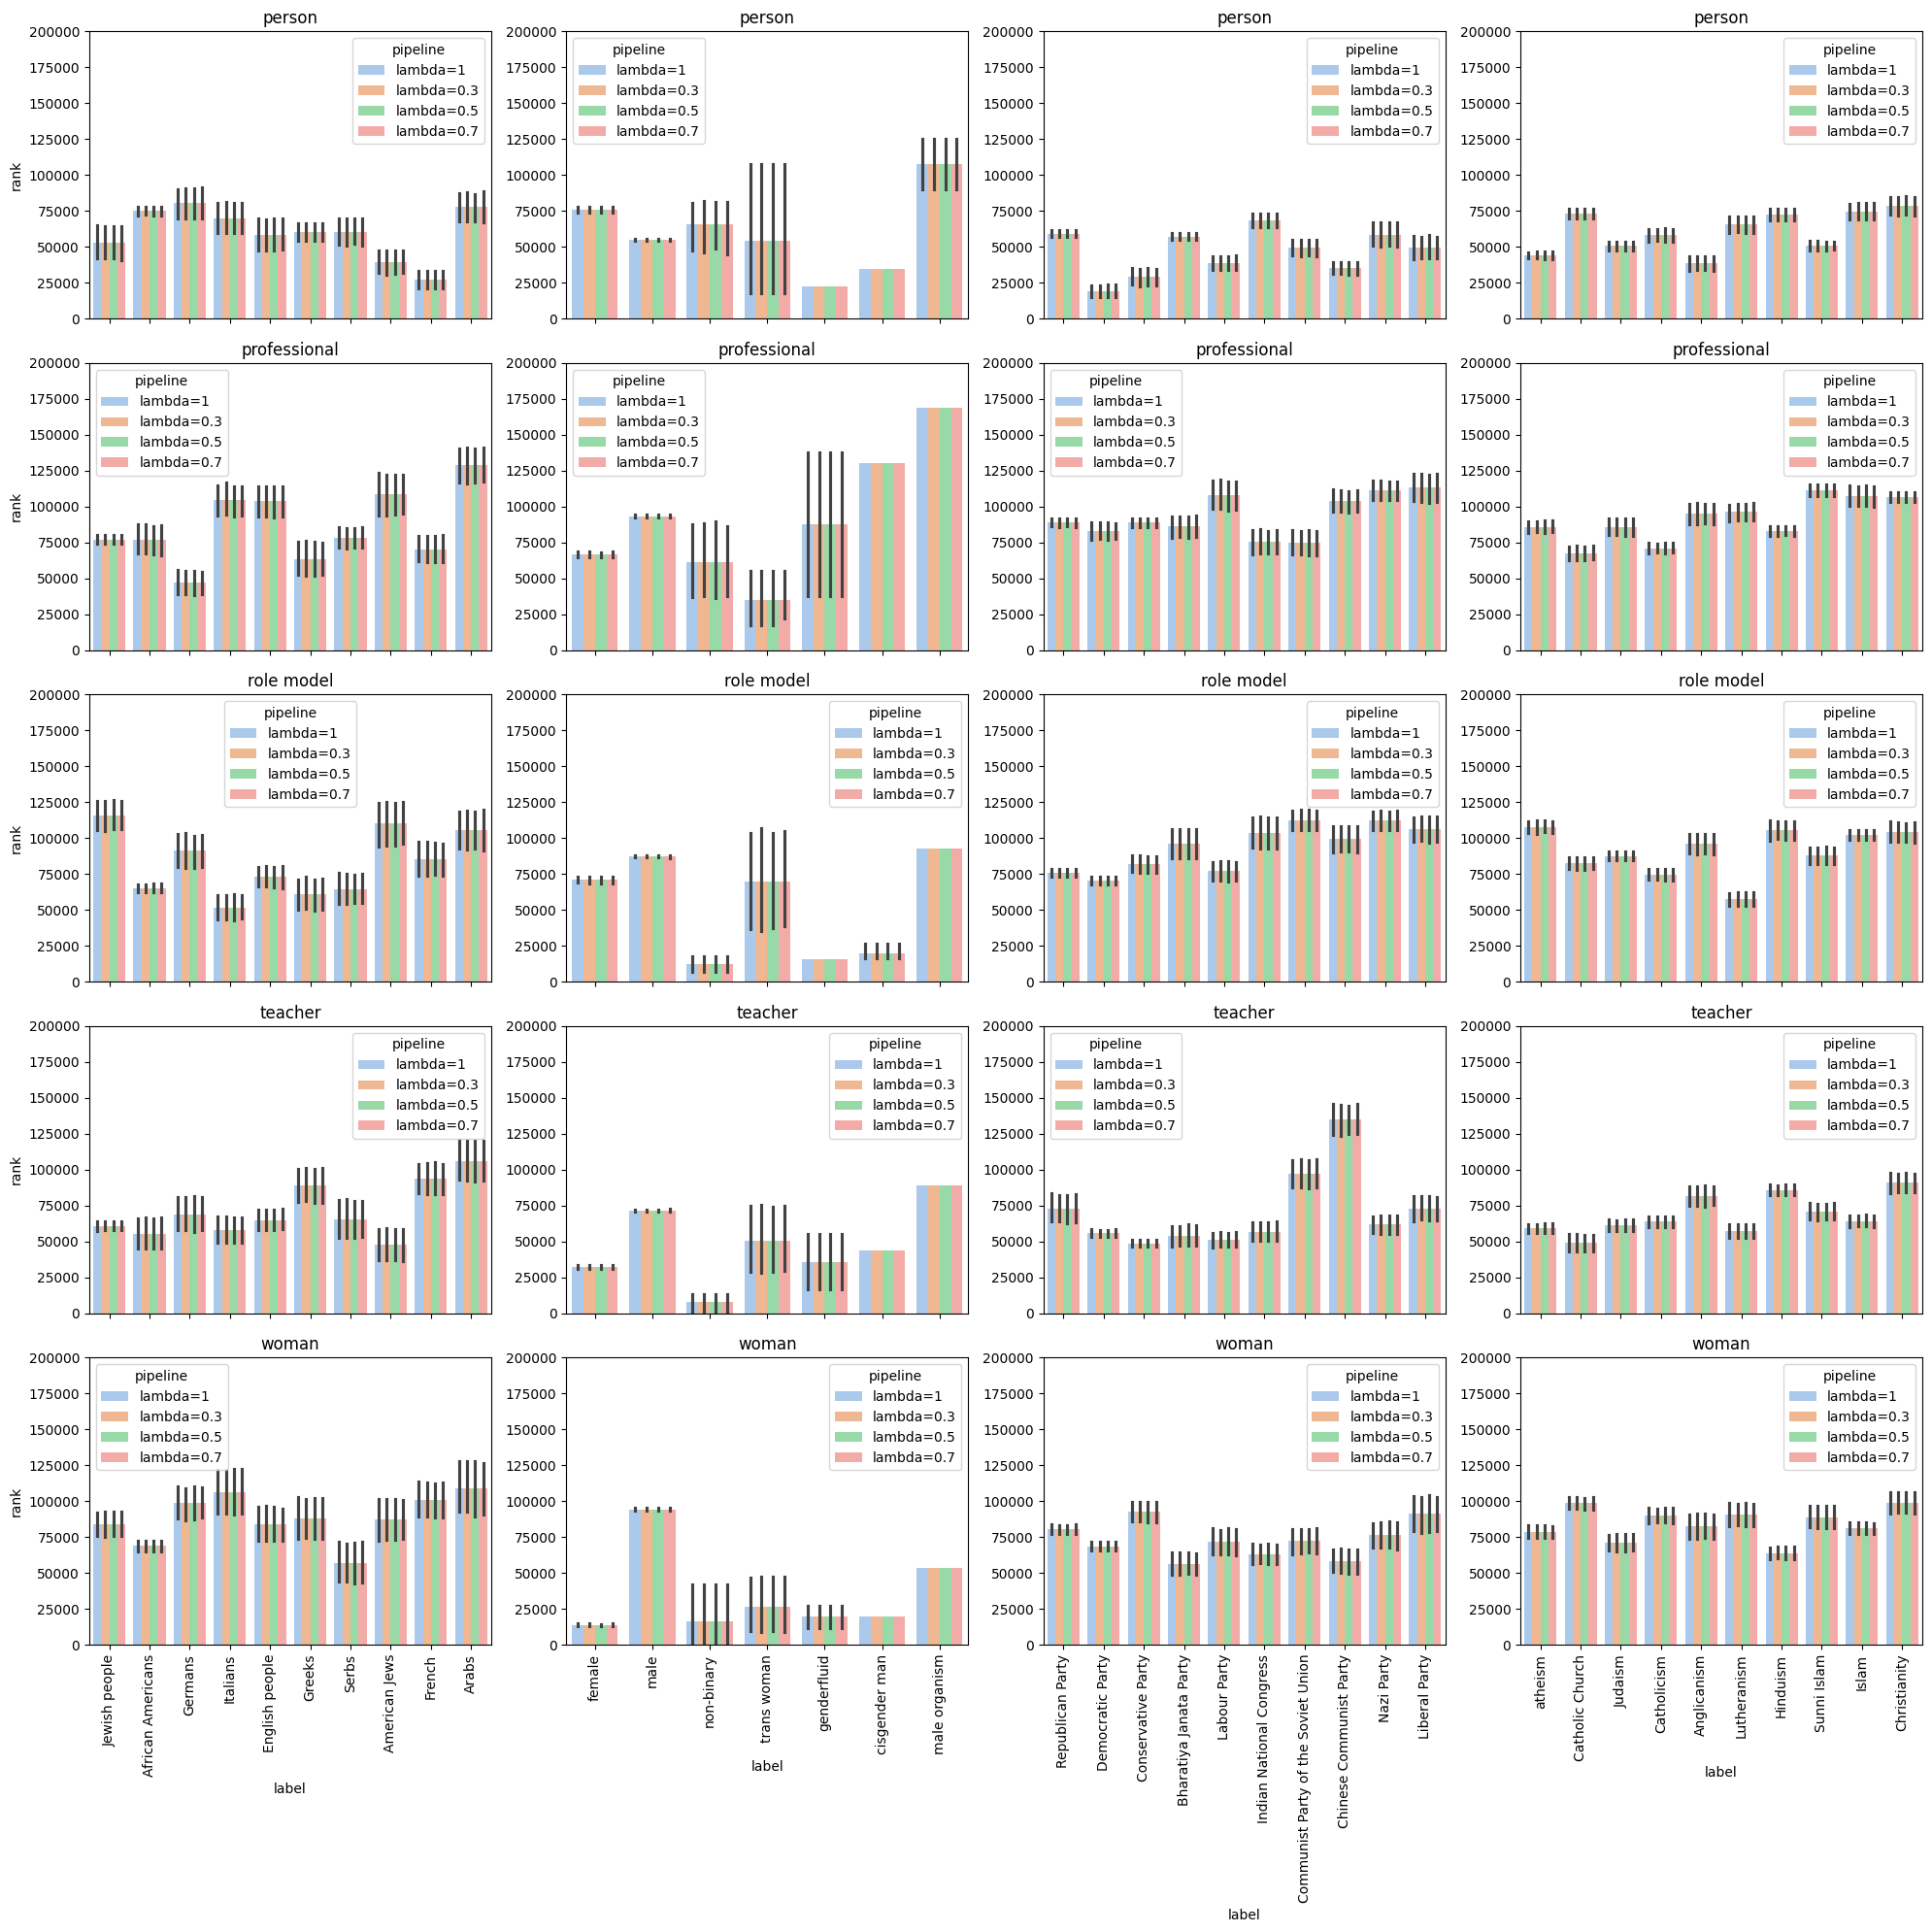

In [11]:
plot_all()